<!DOCTYPE html>
<html>
<head>
<title>Data Science Project</title>
<style>
h1 {
  text-align: center;
  font-size: 3em;
  color: navy;
  font-family: Arial, sans-serif;
  margin-bottom: 0.5em;
}

.editors {
  
  text-align: center;
  font-size: 1.2em;
  color: darkgray;
  font-style: italic;
}

</style>
</head>
<body>

<h1>Image Detection of Tesla Cars</h1>
<div class="editors">Edited by: Ritish Narain, Kenza Tajina, Ranim</div>

</body>
</html>


In [1]:
# !pip install datasets

# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, concatenate_datasets
from PIL import Image
import torchvision.models as models
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
import pickle

# Loading the Dataset

In [3]:
dataset = load_dataset("tanganke/stanford_cars", split=['train', 'test'])
train_df, test_df = dataset 

## Shape and Elements
+ We can see the train and test datasets in the datasets.
+ We have ```8144``` images in the train dataset and ```8041``` in the test dataset.
+ The 2 in each sub-datasets corresponds to the image and its label. For ex: An Image of a Tesla Model Y will have the label ```Tesla Model Y```.

In [4]:
train_df.shape, test_df.shape

((8144, 2), (8041, 2))

# Data Preparation

## The Data split
+ We will take only 200 non-tesla cars for train and test dataset each. We will use all the images of tesla cars.
+ Adding labels to identify Tesla Cars :
  + Tesla cars (1)
  + Not Tesla cars (0)

In [5]:
# 1. Get class names and Tesla indices
class_names = train_df.features['label'].names
tesla_indices = [i for i, name in enumerate(class_names) if 'tesla' in name.lower()]

# 2. Assign binary labels
def assign_binary_label(example):
    example['binary_label'] = 1 if example['label'] in tesla_indices else 0
    return example

train_dataset = train_df.map(assign_binary_label)
test_dataset = test_df.map(assign_binary_label)

# 3. Filter and sample
def filter_and_sample(dataset_split, max_non_tesla=60):
    tesla = dataset_split.filter(lambda ex: ex['binary_label'] == 1)
    non_tesla = dataset_split.filter(lambda ex: ex['binary_label'] == 0).shuffle(seed=42).select(range(max_non_tesla))
    return concatenate_datasets([tesla, non_tesla])

filtered_train = filter_and_sample(train_dataset)
filtered_test = filter_and_sample(test_dataset)


In [6]:
filtered_train.shape, filtered_test.shape # We check the shape size of the datasets

((99, 3), (98, 3))

## Distribution of Tesla cars

In [7]:
train_labels = [example['binary_label'] for example in filtered_train]
test_labels = [example['binary_label'] for example in filtered_test]
print(f"Train set - Tesla: {sum(train_labels)}, Non-Tesla: {len(train_labels) - sum(train_labels)}")
print(f"Test set - Tesla: {sum(test_labels)}, Non-Tesla: {len(test_labels) - sum(test_labels)}")

Train set - Tesla: 39, Non-Tesla: 60
Test set - Tesla: 38, Non-Tesla: 60


## Visual of an image

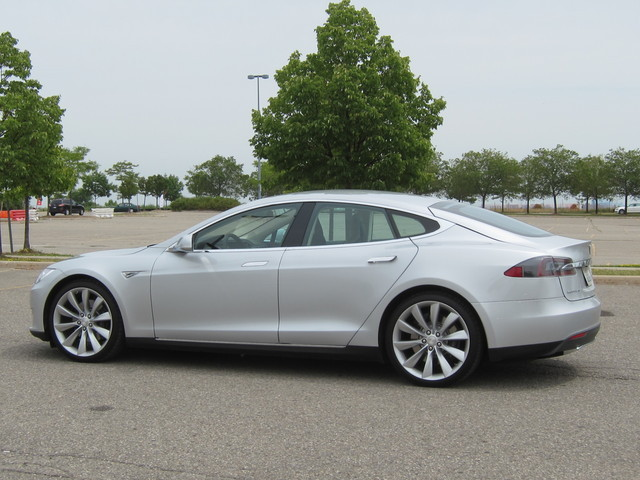

Label: 184 Tesla Model S Sedan 2012


In [8]:
sample_img = filtered_train[0]
img = sample_img['image'] # The image
label = sample_img['label'] # The label
label_name = filtered_train.features['label'].int2str(label) # To display the label name
display(img)
print("Label:", label, label_name)

## Normalisation of images
+ We resize to a common input size of ```300``` for each image with the efficientB3 model.
+ We transform the images to a Pytorch tensor for processing having a range (0,1).
+ Finally, we standardize with a mean and standard deviation to have better model performance and avoid scaling issues. 3 Values are passed to each of the RGB colours.
+ We will add flips of images, random rotation and colour tweaking to have a more robust model.
+ We will use the mean and standard deviation of the ImageNet Statistics in RGB order as follows:

```Mean: [0.485, 0.456, 0.406]```

```Standard Deviation: [0.229, 0.224, 0.225]```

In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


val_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
def apply_transform(example, transform):
    image = example['image']
    
    # Ensure image is PIL and RGB
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    example['image'] = transform(image)
    return example

In [11]:
tesla_train_norm = filtered_train.map(lambda x: apply_transform(x, train_transforms))

In [12]:
tesla_test_norm = filtered_test.map(lambda x: apply_transform(x, val_transforms))

In [13]:
tesla_img_tensor = torch.tensor(tesla_train_norm[0]['image'])
min_value = tesla_img_tensor.min().item()
max_value = tesla_img_tensor.max().item()

print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")

Minimum value: -2.1179039478302
Maximum value: 2.640000104904175


# Using a Pretrained model for transfer learning
+ We will use the ResNet50 with the pretrained model weights.
+ We also modify the model to add the 2 binary classes for Tesla and Not Tesla cars

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1).to(device)
in_features = base_model.classifier[1].in_features
in_features

1536

### Displaying the Layers and weights of the model
+ The format ```(3, 224, 224)``` describes as 3 representing the RGB channels, and 224x224 are the height and width of the image.

In [15]:
summary(base_model, input_size=(3, 300, 300)) # (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 150, 150]           1,080
       BatchNorm2d-2         [-1, 40, 150, 150]              80
              SiLU-3         [-1, 40, 150, 150]               0
            Conv2d-4         [-1, 40, 150, 150]             360
       BatchNorm2d-5         [-1, 40, 150, 150]              80
              SiLU-6         [-1, 40, 150, 150]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 150, 150]               0
           Conv2d-13         [-1, 24, 150, 150]             960
      BatchNorm2d-14         [-1, 24, 1

### Freezing the base model

In [16]:
# Freeze all layers
for param in base_model.parameters():
    param.requires_grad = False

base_model = base_model.to(device)

### Adding a layer to the model
+ The EfficientNet B3 model already includes an AdaptiveAvgPool2d layer, reducing the feature maps to a vector of size 2048. Thus, a pooling layer is not needed.
+ We can see below that we have freezed the existing parameters of the model.
+ Only the classifier layers will be trained.

In [17]:
base_model.classifier = nn.Sequential(
    nn.Linear(in_features, 48),
    nn.ReLU(),
    # nn.BatchNorm1d(48),
    nn.Dropout(0.5),
    nn.Linear(48, 2))

# base_model.classifier = nn.Sequential(nn.Linear(in_features, 2))
base_model = base_model.to(device)

In [18]:
for param in base_model.classifier.parameters():
    param.requires_grad = True

In [19]:
# for idx in [-1]:  # last 1 blocks
#     for param in base_model.features[idx].parameters():
#         param.requires_grad = True

In [20]:
for name, param in base_model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [21]:
summary(base_model, input_size=(3, 300, 300)) # (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 150, 150]           1,080
       BatchNorm2d-2         [-1, 40, 150, 150]              80
              SiLU-3         [-1, 40, 150, 150]               0
            Conv2d-4         [-1, 40, 150, 150]             360
       BatchNorm2d-5         [-1, 40, 150, 150]              80
              SiLU-6         [-1, 40, 150, 150]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 150, 150]               0
           Conv2d-13         [-1, 24, 150, 150]             960
      BatchNorm2d-14         [-1, 24, 1

### Convertion from Hugging Face to PyTorch-compatible datasets
+ We will do batch training for the model to limit memory issues.

In [22]:
class BinaryCarDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['binary_label']

        # Ensuring image is a tensor
        if not isinstance(image, torch.Tensor):
            image = torch.tensor(image, dtype=torch.float32)

        # Converting label to tensor
        label = torch.tensor(label, dtype=torch.long)     # Use long for classification labels

        return image, label

In [23]:
train_datanorm_py = BinaryCarDataset(tesla_train_norm)
test_datanorm_py = BinaryCarDataset(tesla_test_norm)

In [24]:
batch_size = 48
train_loader = DataLoader(train_datanorm_py, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory = True)
test_loader = DataLoader(test_datanorm_py, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory = True)

### Class imbalance handling with weights

In [25]:
labels = [example['binary_label'] for example in tesla_train_norm]
class_counts = np.bincount(labels)
total_samples = len(labels)

class_weights = np.zeros_like(class_counts, dtype=np.float32)
for i, count in enumerate(class_counts):
    if count > 0:
        class_weights[i] = total_samples / (len(class_counts) * count)
    else:
        class_weights[i] = 0 # To avoid div 0

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class weights (Not Tesla, Tesla): {class_weights}")

Class weights (Not Tesla, Tesla): [0.825     1.2692307]


### The model
+ We define the loss and optimizer function
+ We use the GPU for training the model

In [26]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered!")
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0

In [27]:
lr = 0.0001
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
optimizer = optim.Adam(base_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=True)
class_weights_tensor = class_weights_tensor.to(device)
base_model = base_model.to(device)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training the model with frozen layers
+ The phase 1 is training the model with the base_model parameters frozen

In [28]:
# torch.cuda.empty_cache()
# del base_model
# torch.cuda.reset_peak_memory_stats()

In [29]:
train_losses = []
val_losses = []
num_epochs_phase1 = 200

for epoch in range(num_epochs_phase1):
    base_model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs_phase1}, Train Loss: {train_loss:.4f}")

    base_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = base_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(test_loader)
    val_losses.append(val_loss)

    early_stopping(val_loss, base_model)
    if early_stopping.early_stop:
        break
    
    print(f"Epoch {epoch+1}/{num_epochs_phase1}, Validation Loss: {val_loss:.4f}")

Epoch 1/200, Train Loss: 0.7089
Epoch 1/200, Validation Loss: 0.6757
Epoch 2/200, Train Loss: 0.6994
Epoch 2/200, Validation Loss: 0.6755
Epoch 3/200, Train Loss: 0.6688
Epoch 3/200, Validation Loss: 0.6738
Epoch 4/200, Train Loss: 0.6647
Epoch 4/200, Validation Loss: 0.6717
Epoch 5/200, Train Loss: 0.7129
Epoch 5/200, Validation Loss: 0.6702
Epoch 6/200, Train Loss: 0.6826
Epoch 6/200, Validation Loss: 0.6701
Epoch 7/200, Train Loss: 0.7078
Epoch 7/200, Validation Loss: 0.6676
Epoch 8/200, Train Loss: 0.6805
Epoch 8/200, Validation Loss: 0.6662
Epoch 9/200, Train Loss: 0.6756
Epoch 9/200, Validation Loss: 0.6660
Epoch 10/200, Train Loss: 0.6763
EarlyStopping counter: 1 out of 7
Epoch 10/200, Validation Loss: 0.6664
Epoch 11/200, Train Loss: 0.6629
Epoch 11/200, Validation Loss: 0.6654
Epoch 12/200, Train Loss: 0.6735
Epoch 12/200, Validation Loss: 0.6625
Epoch 13/200, Train Loss: 0.6701
EarlyStopping counter: 1 out of 7
Epoch 13/200, Validation Loss: 0.6631
Epoch 14/200, Train Loss: 0

### Train and Validation loss for the model with frozen parameters

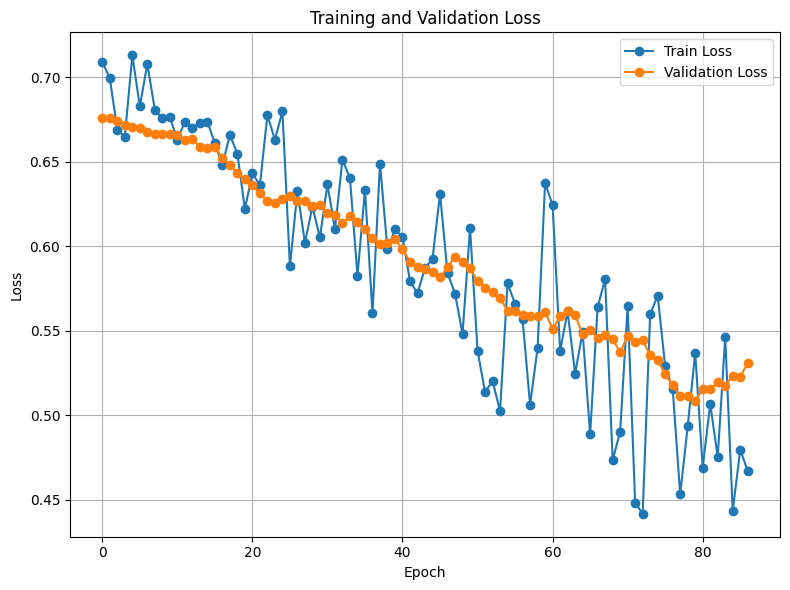

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Training the model with unfrozen layers
+ We unfreeze the last 8 layers only due to memory constraints.

In [31]:
for name, param in base_model.named_parameters():
    if param.requires_grad:
        print(f"Unfrozen layer: {name}")

Unfrozen layer: classifier.0.weight
Unfrozen layer: classifier.0.bias
Unfrozen layer: classifier.3.weight
Unfrozen layer: classifier.3.bias


In [32]:
for idx in [-1]:  # last 1 blocks
    for param in base_model.features[idx].parameters():
        param.requires_grad = True

In [33]:
summary(base_model, input_size=(3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 150, 150]           1,080
       BatchNorm2d-2         [-1, 40, 150, 150]              80
              SiLU-3         [-1, 40, 150, 150]               0
            Conv2d-4         [-1, 40, 150, 150]             360
       BatchNorm2d-5         [-1, 40, 150, 150]              80
              SiLU-6         [-1, 40, 150, 150]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 150, 150]               0
           Conv2d-13         [-1, 24, 150, 150]             960
      BatchNorm2d-14         [-1, 24, 1

In [34]:
optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-5)
num_epochs_phase2 = 200
# Initialize lists to collect all predictions and labels for final evaluation
all_labels_overall = []
all_preds_overall = []
all_probs_overall = []

metrics_history = {
    'train_losses': [],
    'val_losses': [],
    'accuracy': [],
    'f1_score': [],
    'roc_auc': []}

for epoch in range(num_epochs_phase2):
    base_model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    metrics_history['train_losses'].append(train_loss)
    print(f"Phase 2 - Epoch {epoch+1}/{num_epochs_phase2}, Train Loss: {train_loss:.4f}")

    #Saving for streamlit
    with open('metrics_history.pkl', 'wb') as f:
      pickle.dump(metrics_history, f)

    base_model.eval()
    val_loss = 0
    all_labels_epoch = []
    all_preds_epoch = []
    all_probs_epoch = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = base_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probability for class 1 (Tesla)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_labels_epoch.extend(labels.cpu().numpy())
            all_preds_epoch.extend(preds)
            all_probs_epoch.extend(probs)


    val_loss = val_loss / len(test_loader)
    metrics_history['val_losses'].append(val_loss)
    print(f"Phase 2 - Validation Loss: {val_loss:.4f}")

    accuracy = accuracy_score(all_labels_epoch, all_preds_epoch)
    f1 = f1_score(all_labels_epoch, all_preds_epoch)
    roc_auc = roc_auc_score(all_labels_epoch, all_probs_epoch)
    metrics_history['accuracy'].append(accuracy)
    metrics_history['f1_score'].append(f1)
    metrics_history['roc_auc'].append(roc_auc)
    print(f"Phase 2 - Epoch {epoch+1} Metrics - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC_AUC: {roc_auc:.4f}")

    # Collect for final overall metrics
    all_labels_overall.extend(all_labels_epoch)
    all_preds_overall.extend(all_preds_epoch)
    all_probs_overall.extend(all_probs_epoch)
    torch.save(base_model.state_dict(), "model_weights.pth")

    class_names = ['Non-Tesla', 'Tesla']
    with open('class_names.pkl', 'wb') as f:
      pickle.dump(class_names, f)


Phase 2 - Epoch 1/200, Train Loss: 0.5161
Phase 2 - Validation Loss: 0.5320
Phase 2 - Epoch 1 Metrics - Accuracy: 0.8980, F1: 0.8780, ROC_AUC: 0.9509
Phase 2 - Epoch 2/200, Train Loss: 0.4791
Phase 2 - Validation Loss: 0.5320
Phase 2 - Epoch 2 Metrics - Accuracy: 0.8980, F1: 0.8810, ROC_AUC: 0.9487
Phase 2 - Epoch 3/200, Train Loss: 0.4584
Phase 2 - Validation Loss: 0.5404
Phase 2 - Epoch 3 Metrics - Accuracy: 0.8878, F1: 0.8706, ROC_AUC: 0.9500
Phase 2 - Epoch 4/200, Train Loss: 0.5029
Phase 2 - Validation Loss: 0.5344
Phase 2 - Epoch 4 Metrics - Accuracy: 0.8980, F1: 0.8780, ROC_AUC: 0.9487
Phase 2 - Epoch 5/200, Train Loss: 0.5081
Phase 2 - Validation Loss: 0.5330
Phase 2 - Epoch 5 Metrics - Accuracy: 0.8980, F1: 0.8780, ROC_AUC: 0.9509
Phase 2 - Epoch 6/200, Train Loss: 0.5424
Phase 2 - Validation Loss: 0.5365
Phase 2 - Epoch 6 Metrics - Accuracy: 0.8980, F1: 0.8810, ROC_AUC: 0.9570
Phase 2 - Epoch 7/200, Train Loss: 0.4726
Phase 2 - Validation Loss: 0.5408
Phase 2 - Epoch 7 Metric

In [ ]:
train_losses = metrics_history['train_losses']
val_losses = metrics_history['val_losses']
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()